# Lab | Making predictions with logistic regression

In this lab, you will be using the Sakila database of movie rentals.

In order to optimize our inventory, we would like to know which films will be rented next month and we are asked to create a model to predict it.
Instructions

    1 Create a query or queries to extract the information you think may be relevant for building the prediction model. It should include some film features and some rental features.
    
    2 Read the data into a Pandas dataframe.
    
    3 Analyze extracted features and transform them. You may need to encode some categorical variables, or scale numerical variables.
    
    4 Create a query to get the list of films and a boolean indicating if it was rented last month. This would be our target variable.
    
    5 Create a logistic regression model to predict this variable from the cleaned data.
    
    6 Evaluate the results.

In [1]:
from sqlalchemy import create_engine
import pandas as pd
import getpass  # To get the password without showing the input
password = getpass.getpass()

········


In [2]:
import numpy as np
import seaborn as sns
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

import warnings
warnings.filterwarnings('ignore')

## Read data into Pandas dataframe.

In [3]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)

In [4]:
query = '''select 
	distinct f.film_id,
    count(r.rental_id) as nr_of_rentals, 
    fc.category_id, 
    f.rental_duration,
    f.rental_rate, 
    f.rating, 
    f.release_year, 
    f.length,  
    case
	when f.film_id in (
		select film_id 
        from rental as r
		join inventory as i
		using(inventory_id)
		join film as f
		using(film_id)
		where date_format(convert(r.rental_date,date), '%Y-%m') ='2006-02') then 1
	else 0
	end as rented_last_month
from rental r
right join inventory i on r.inventory_id = i.inventory_id
right join film f on i.film_id = f.film_id
join film_category fc on f.film_id = fc.film_id
group by f.film_id
order by f.film_id;'''

data = pd.read_sql_query(query, engine)
data.head()

,film_id,nr_of_rentals,category_id,rental_duration,rental_rate,rating,release_year,length,rented_last_month
0,1,24,6,6,0.99,PG,2006,86,0
1,2,7,11,3,4.99,G,2006,48,1
2,3,12,6,7,2.99,NC-17,2006,50,0
3,4,23,11,5,2.99,G,2006,117,1
4,5,12,8,6,2.99,G,2006,130,1


## Analyze and transform the data.

In [5]:
data.shape

(1000, 9)

In [6]:
#checking data types
data.dtypes

film_id                int64
nr_of_rentals          int64
category_id            int64
rental_duration        int64
rental_rate          float64
rating                object
release_year           int64
length                 int64
rented_last_month      int64
dtype: object

In [7]:
#data.set_index('film_id')

In [8]:
#drop 'film_id' since it consists of unique values
data = data.drop('film_id', axis=1)

In [9]:
#checking column 'release_year'
data['release_year'].unique()

array([2006], dtype=int64)

In [10]:
#drop 'release year' since it's only one value (2006)
data = data.drop('release_year', axis=1)
data.head()

,nr_of_rentals,category_id,rental_duration,rental_rate,rating,length,rented_last_month
0,24,6,6,0.99,PG,86,0
1,7,11,3,4.99,G,48,1
2,12,6,7,2.99,NC-17,50,0
3,23,11,5,2.99,G,117,1
4,12,8,6,2.99,G,130,1


In [11]:
data['category_id'] = data['category_id'].astype('object')
data['rental_rate'] = data['rental_rate'].astype('object')
data['rented_last_month'] = data['rented_last_month'].astype('bool')
data.dtypes

nr_of_rentals         int64
category_id          object
rental_duration       int64
rental_rate          object
rating               object
length                int64
rented_last_month      bool
dtype: object

In [12]:
#checking null values
data.isna().sum()

nr_of_rentals        0
category_id          0
rental_duration      0
rental_rate          0
rating               0
length               0
rented_last_month    0
dtype: int64

In [13]:
data.describe().T
#only numerical data

,count,mean,std,min,25%,50%,75%,max
nr_of_rentals,1000.0,16.045,7.349080,0.0,11.0,16.0,21.00,34.0
rental_duration,1000.0,4.985,1.411654,3.0,4.0,5.0,6.00,7.0
length,1000.0,115.272,40.426332,46.0,80.0,114.0,149.25,185.0


In [14]:
data.describe(include=[np.object]).T

,count,unique,top,freq
category_id,1000,16,15,74
rental_rate,1000,3,0.99,341
rating,1000,5,PG-13,223


## Extract the target variable.

In [15]:
Y = data['rented_last_month']
#target variable is a boolean

In [16]:
Y.value_counts()
#highly imbalanced

False    832
True     168
Name: rented_last_month, dtype: int64

## Extract & transform independent variables.

In [17]:
X = data.drop(['rented_last_month'], axis = 1)

In [18]:
X.columns

Index(['nr_of_rentals', 'category_id', 'rental_duration', 'rental_rate',
       'rating', 'length'],
      dtype='object')

### Split numerical & categorical columns.

In [19]:
X_num = X.select_dtypes(np.number)
X_num.head()

,nr_of_rentals,rental_duration,length
0,24,6,86
1,7,3,48
2,12,7,50
3,23,5,117
4,12,6,130


In [20]:
X_cat = X.select_dtypes(np.object)
X_cat.head()

,category_id,rental_rate,rating
0,6,0.99,PG
1,11,4.99,G
2,6,2.99,NC-17
3,11,2.99,G
4,8,2.99,G


### Transform numerical columns.

#### Check multicollinearity of numerical columns.

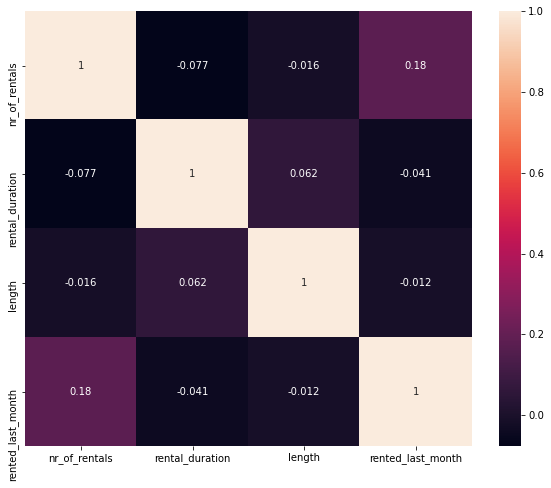

In [41]:
corr_matrix = data.corr(method='pearson')
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

#only very little correlation between variables so prediction will be hard

#### Option 1: StandardScaler

In [22]:
transformer = StandardScaler().fit(X_num)
X_scaled = pd.DataFrame(transformer.transform(X_num))
#X_scaled = pd.DataFrame(X_scaled)
print(X_scaled.shape)

(1000, 3)


In [23]:
X_scaled.columns = X_num.columns
X_scaled.columns

Index(['nr_of_rentals', 'rental_duration', 'length'], dtype='object')

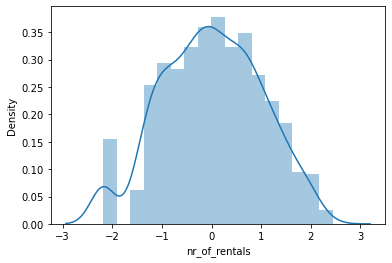

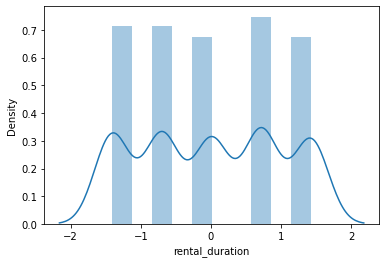

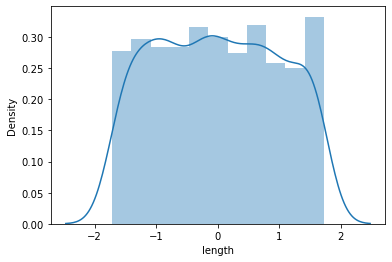

In [24]:
for col in X_scaled:
    sns.distplot(X_scaled[col])
    plt.show()

#### Option 2: Normalizer

In [25]:
transformer = Normalizer().fit(X_num)
X_num_norm = pd.DataFrame(transformer.transform(X_num))
print(X_num_norm.shape)

(1000, 3)


In [26]:
X_num_norm.columns = X_num.columns
X_num_norm.columns

Index(['nr_of_rentals', 'rental_duration', 'length'], dtype='object')

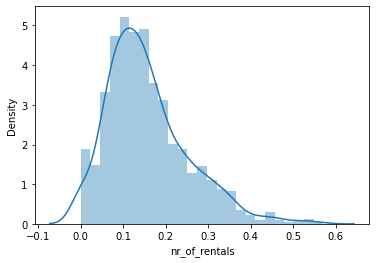

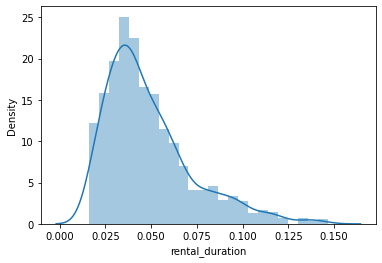

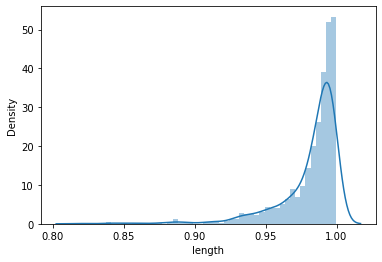

In [27]:
for col in X_num_norm:
    sns.distplot(X_num_norm[col])
    plt.show()

### Transform categorical columns.

In [28]:
#Dummyfy categorical data.

X_cat_dummy = pd.get_dummies(X_cat)
X_cat_dummy.head()

,category_id_1,category_id_2,category_id_3,category_id_4,category_id_5,category_id_6,category_id_7,category_id_8,category_id_9,category_id_10,category_id_11,category_id_12,category_id_13,category_id_14,category_id_15,category_id_16,rental_rate_0.99,rental_rate_2.99,rental_rate_4.99,rating_G,rating_NC-17,rating_PG,rating_PG-13,rating_R
0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0


### Concat numerical & categorical columns.

In [29]:
X = pd.concat((X_num_norm, X_cat_dummy), axis = 1)
X.head()

,nr_of_rentals,rental_duration,length,category_id_1,category_id_2,category_id_3,category_id_4,category_id_5,category_id_6,category_id_7,category_id_8,category_id_9,category_id_10,category_id_11,category_id_12,category_id_13,category_id_14,category_id_15,category_id_16,rental_rate_0.99,rental_rate_2.99,rental_rate_4.99,rating_G,rating_NC-17,rating_PG,rating_PG-13,rating_R
0,0.268194,0.067049,0.961029,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
1,0.144032,0.061728,0.987646,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0
2,0.231240,0.134890,0.963500,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
3,0.192720,0.041896,0.980359,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0
4,0.091820,0.045910,0.994717,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0


In [31]:
X.shape

(1000, 27)

## Create the logistic regression model.

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=100)

In [33]:
classification = LogisticRegression(random_state=0, max_iter = 1000, solver='lbfgs',
                  multi_class='ovr').fit(X_train, y_train)

#note to myself: Y has to be numerical or a boolean to create the logistic regression model

## Evaluate the model.

In [34]:
print("The accuracy of the model is: ",round(classification.score(X_test, y_test),2))
print("The kappa of the model is: ",round(cohen_kappa_score(Y,classification.predict(X)),2))

The accuracy of the model is:  0.85
The kappa of the model is:  0.0


In [38]:
predictions = classification.predict(X_test)
#predictions

In [39]:
confusion_matrix(y_test, classification.predict(X_test))

array([[339,   0],
       [ 61,   0]], dtype=int64)

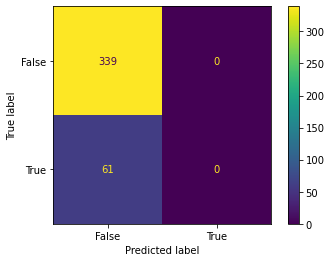

In [40]:
plot_confusion_matrix(classification, X_test, y_test)

> prediction model doesn't work; a reason could be the imbalance of the target variable